In [8]:
import os
import glob
import yaml
import re

import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl

import matplotlib as mpl

import plotting as putil
import dlc as dlc
import utils as util

import importlib

In [9]:
%matplotlib notebook

In [10]:
plot_style='dark'
putil.set_sns_style(style=plot_style)
bg_color='w' if plot_style=='dark' else 'k'

In [11]:
#rootdir = '/mnt/minerva/courtship-free-behavior/maDLCv2' #maDLCv2'

rootdir = '/Users/julianarhee/DeepLabCut'
projectname = 'projector-1dot-jyr-2024-02-18'
project_dir = os.path.join(rootdir, projectname) 
# load config file
cfg_fpath = os.path.join(project_dir, 'config.yaml')
with open(cfg_fpath, "r") as f:
    cfg = yaml.load(f, Loader=yaml.SafeLoader)

In [207]:
minerva_base = '/Volumes/Julie/2d-projector-analysis'
analyzed_dir = os.path.join(minerva_base, 'DeepLabCut', projectname) #'analyzed')

analyzed_files = glob.glob(os.path.join(analyzed_dir, '*_el.h5'))
print("Found {} analyzed files".format(len(analyzed_files)))
#analyzed_files

Found 14 analyzed files


In [208]:
figdir = os.path.join(minerva_base, 'figures')
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [209]:
fpath = analyzed_files[2]
trk = pd.read_hdf(fpath) #os.path.join(pathname, filename))
scorer = trk.columns.get_level_values(0)[0]
fps = 60  # Hz
max_jump = 6
tstamp = np.linspace(0, len(trk) * 1 / fps, len(trk))
nframes = len(trk)

In [42]:
importlib.reload(dlc)

<module 'dlc' from '/Users/julianarhee/Repositories/flytracker-analysis/dlc.py'>

In [46]:
flyid = 'fly' # double check in the plots for abdomen lengths
dotid = 'single'

# flypos = trk.xs(flyid, level='individuals', axis=1)
# dotpos = trk.xs(dotid, level='individuals', axis=1)
fpath = analyzed_files[0]
print(os.path.split(fpath)[-1])
fps = 60  # Hz
max_jump=4
plot_checks= True

data_id = os.path.split(fpath)[-1]
sess_id = data_id.split('DLC')[0]
flydf = dlc.load_trk_df(fpath, flyid='fly', fps=fps, max_jump=max_jump, cop_ix=None)
dotdf = dlc.load_trk_df(fpath, flyid='single', fps=fps, max_jump=max_jump, cop_ix=None)
flydf, dotdf = dlc.get_interfly_params(flydf, dotdf, cop_ix=None)


20240212-1230_fly3_Dmel_sP1-ChR_3do_sh_4x4_2024-02-12-122911-0000DLC_dlcrnetms5_projector-1dotFeb18shuffle1_50000_el.h5


<IPython.core.display.Javascript object>


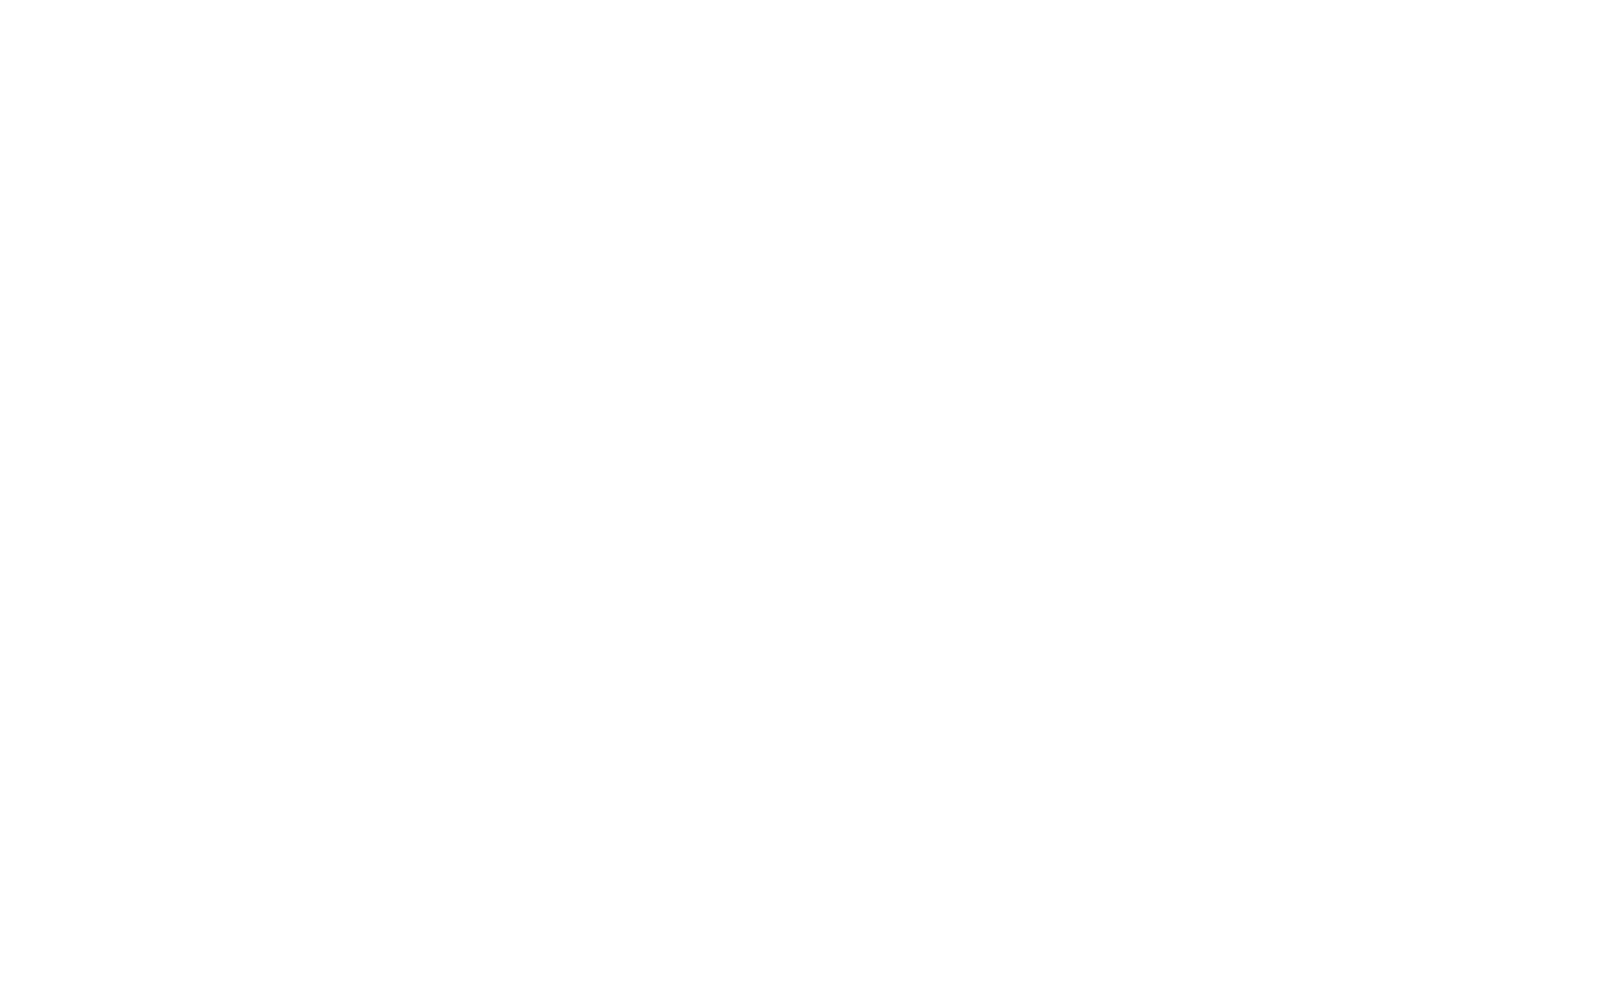

In [47]:
dotdf = dlc.smooth_speed_steps(dotdf)
if plot_checks:
    fig, ax = pl.subplots(figsize=(8, 5))
    sns.scatterplot(x='time', y='centroid_x', data=dotdf, ax=ax,
                    hue='lin_speed_filt', palette='viridis', edgecolor='none', s=5)
    putil.label_figure(fig, data_id)
    pl.savefig(os.path.join(figdir, '{}_color-vel.png'.format(sess_id)))
    pl.close()

<IPython.core.display.Javascript object>


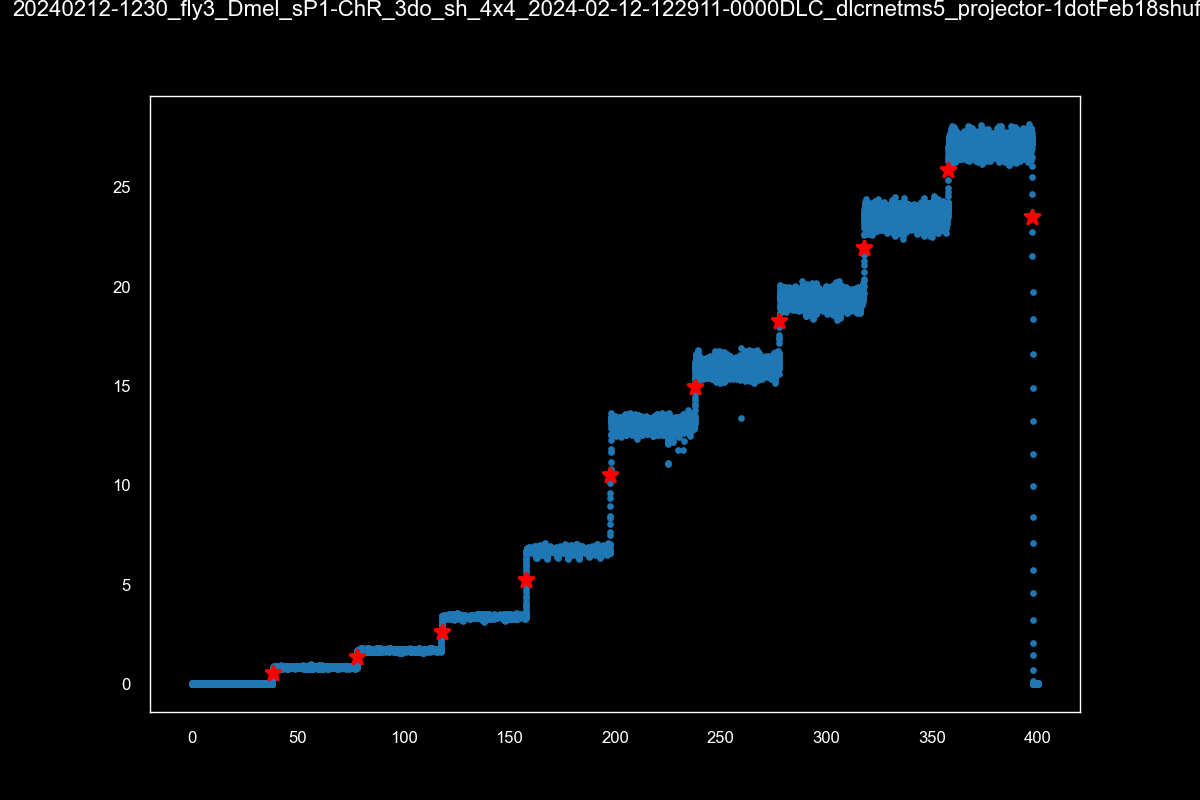

In [49]:
step_dict = dlc.get_step_indices(dotdf, speed_var='lin_speed_filt', 
                             t_start=20, increment=40, n_levels=10)
if plot_checks:
    fig = dlc.check_speed_steps(dotdf, step_dict)
    putil.label_figure(fig, data_id)
    pl.savefig(os.path.join(figdir, '{}_step-ixs.png'.format(sess_id)))
    #pl.close()

In [50]:
dotdf = dlc.add_speed_epoch(dotdf, step_dict)
flydf = dlc.add_speed_epoch(flydf, step_dict)

dotdf = dotdf[dotdf['epoch'] < 10]
flydf = flydf[flydf['epoch'] < 10]

# FFT

In [210]:

target_freqs = {0: 0,
                1: 0.03,
                2: 0.05,
                3: 0.1,
                4: 0.2,
                5: 0.4,
                6: 0.5,
                7: 0.63,
                8: 0.8,
                9: 1.0}

In [211]:
importlib.reload(util)

<module 'utils' from '/Users/julianarhee/Repositories/flytracker-analysis/utils.py'>

In [212]:
plot_each=True

In [213]:
def do_fft_by_epoch(flydf, dotdf, plot=False):
    if plot:
        fig, axn= pl.subplots(10, 1, figsize=(6, 12))
    d_list = []
    for ai, (v, df_) in enumerate(dotdf.groupby('epoch')):
        #print(ai)
        # dot FFT
        dot_amp, dot_freq = util.get_fft(df_, fft_var='centroid_x', time_var='time')
        # fly
        flydf_ = flydf[flydf['epoch']==v].copy()
        fly_amp, fly_freq = util.get_fft(flydf_, fft_var='centroid_x',  time_var='time')
        # get amp at target freq
        target_freq_ix = np.argmin(abs(fly_freq-target_freqs[v]))
        amp_at_targ_dot = dot_amp[target_freq_ix]
        amp_at_targ_fly = fly_amp[target_freq_ix]
        # get freq at max amp
        max_amp_ix_fly = np.argmax(fly_amp)
        freq_at_max_fly = fly_freq[max_amp_ix_fly]
        max_amp_ix_dot = np.argmax(dot_amp)
        freq_at_max_dot = dot_freq[max_amp_ix_dot]

        d1 =pd.DataFrame({'epoch': v,
                     'target_freq': target_freqs[v],
                     'freq_at_max': freq_at_max_dot,
                     'amp_at_targ': amp_at_targ_dot,
                     'id': 'dot'}, index=[ai])
        d2 =pd.DataFrame({'epoch': v,
                     'target_freq': target_freqs[v],
                     'freq_at_max': freq_at_max_fly,
                     'amp_at_targ': amp_at_targ_fly,
                     'id': 'fly'}, index=[ai])
        d_ = pd.concat([d1, d2], axis=0)
        d_list.append(d_)

        # plot
        if plot:
            # plot
            ax=axn.flat[ai]
            ax.stem(dot_freq, dot_amp, 'w', markerfmt=" ", basefmt="-w")
            ax.stem(fly_freq, fly_amp, 'r', markerfmt=" ", basefmt="-r")
            ax.set_xlim([0, 1.5])
            # get max of DOT
            max_ix = np.argmax(amp)
            ax.set_title('{}: {}Hz'.format(v, freq[max_ix].round(2)), loc='left')
        #pl.subplots_adjust(hspace=0.7)
    if plot_each:
        pl.tight_layout()

    fft_ = pd.concat(d_list)
    if plot:
        return fft_, fig
    else:
        return fft_

20240212-1230_fly3_Dmel_sP1-ChR_3do_sh_4x4_2024-02-12-122911-0000


<IPython.core.display.Javascript object>


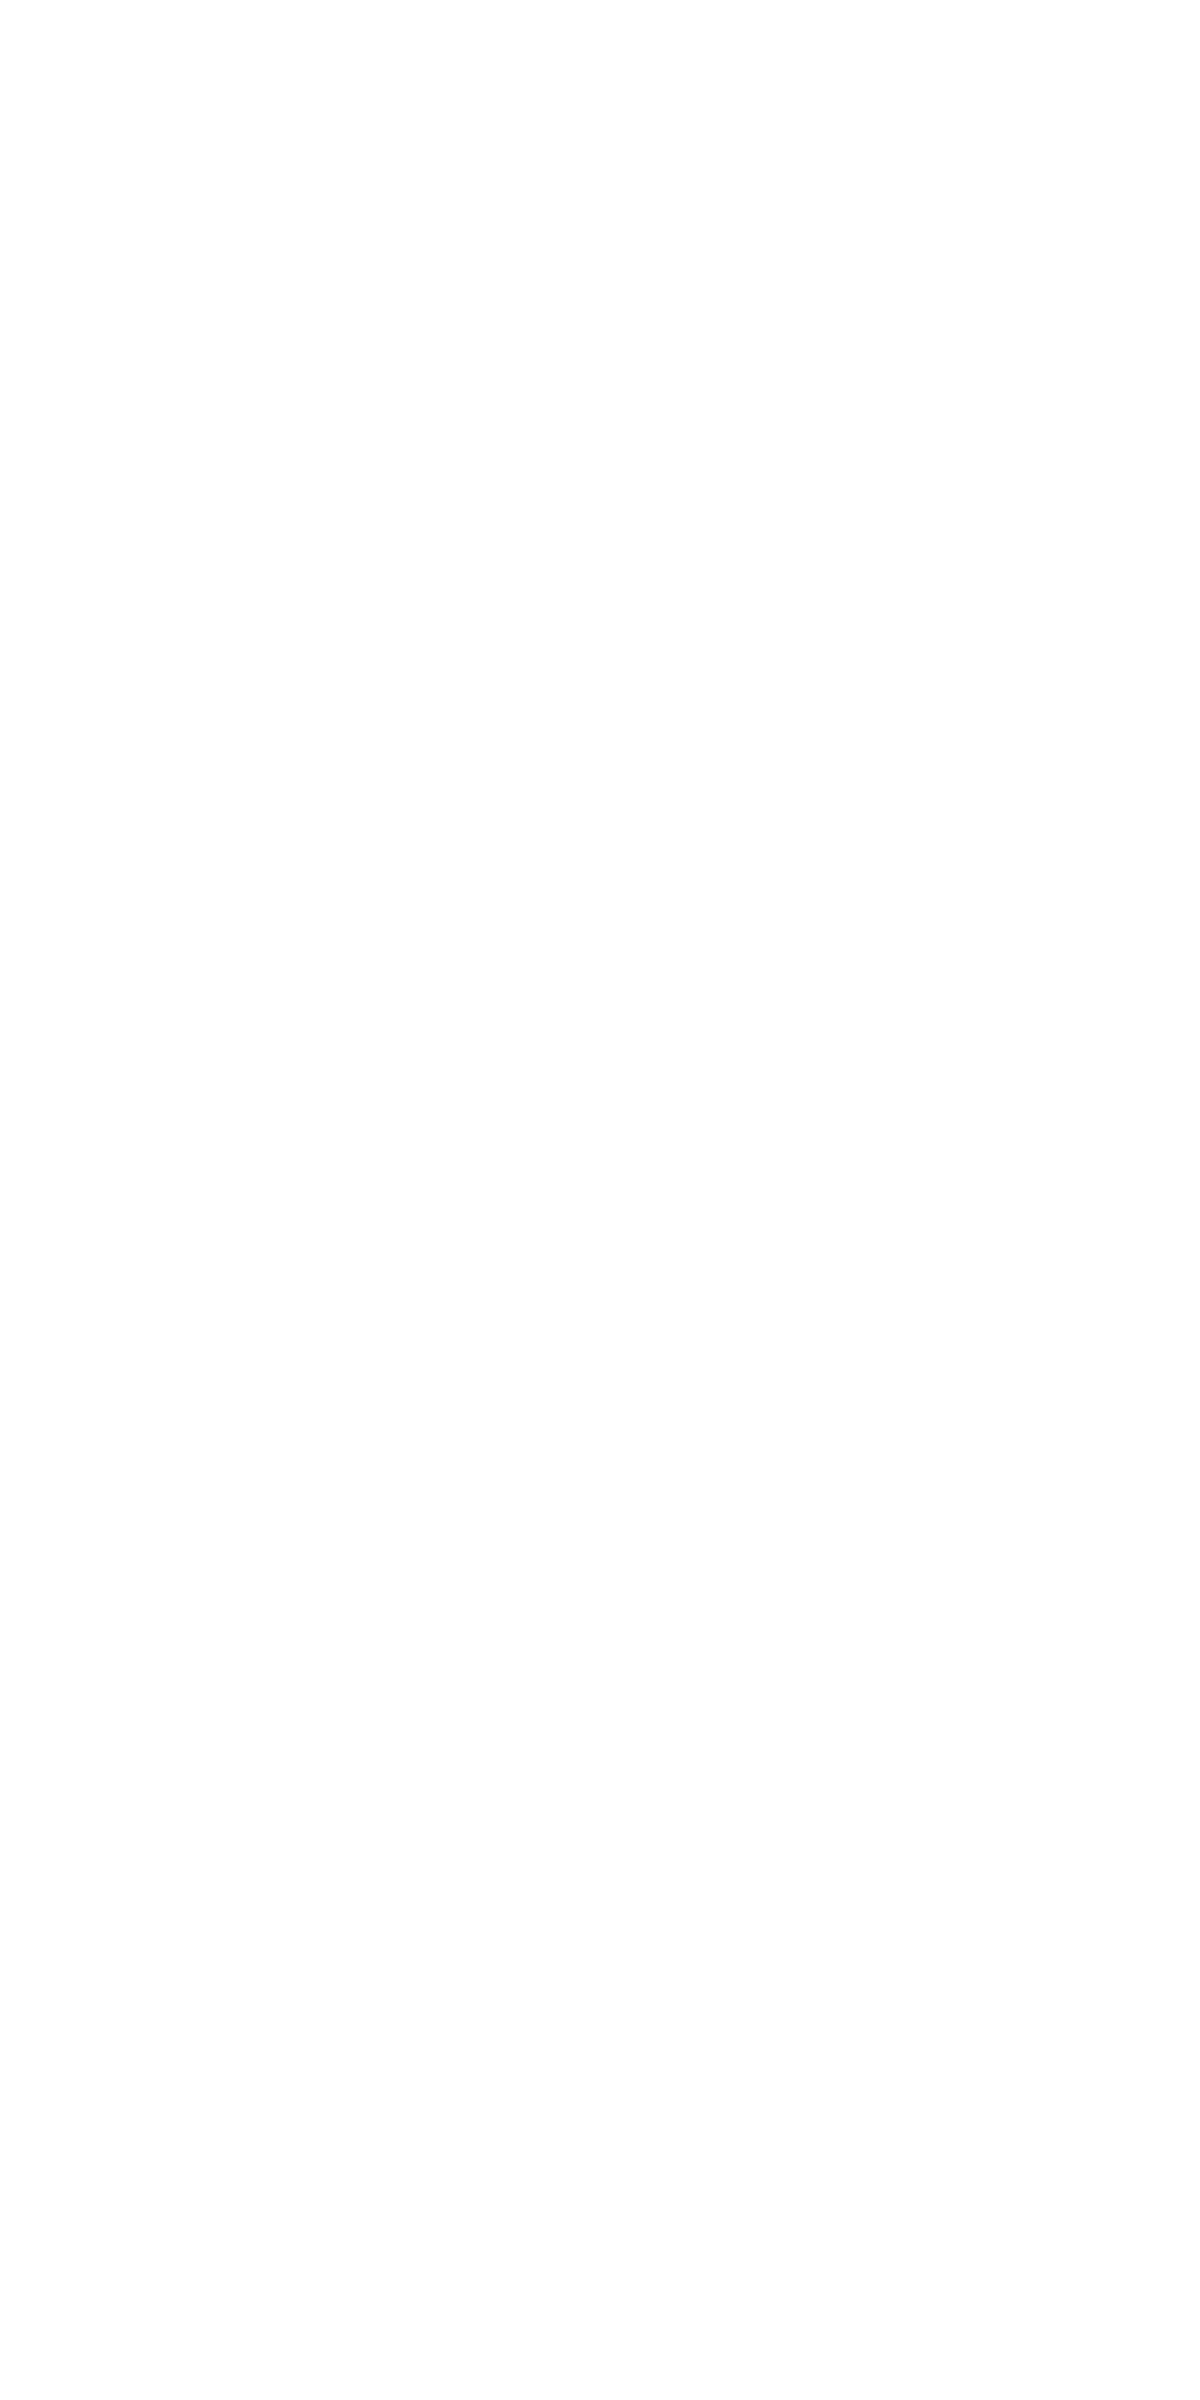

20240214-0945_f1_Dele-wt_5do_sh_prj10_sz6x6_2024-02-14-094517-0000


<IPython.core.display.Javascript object>


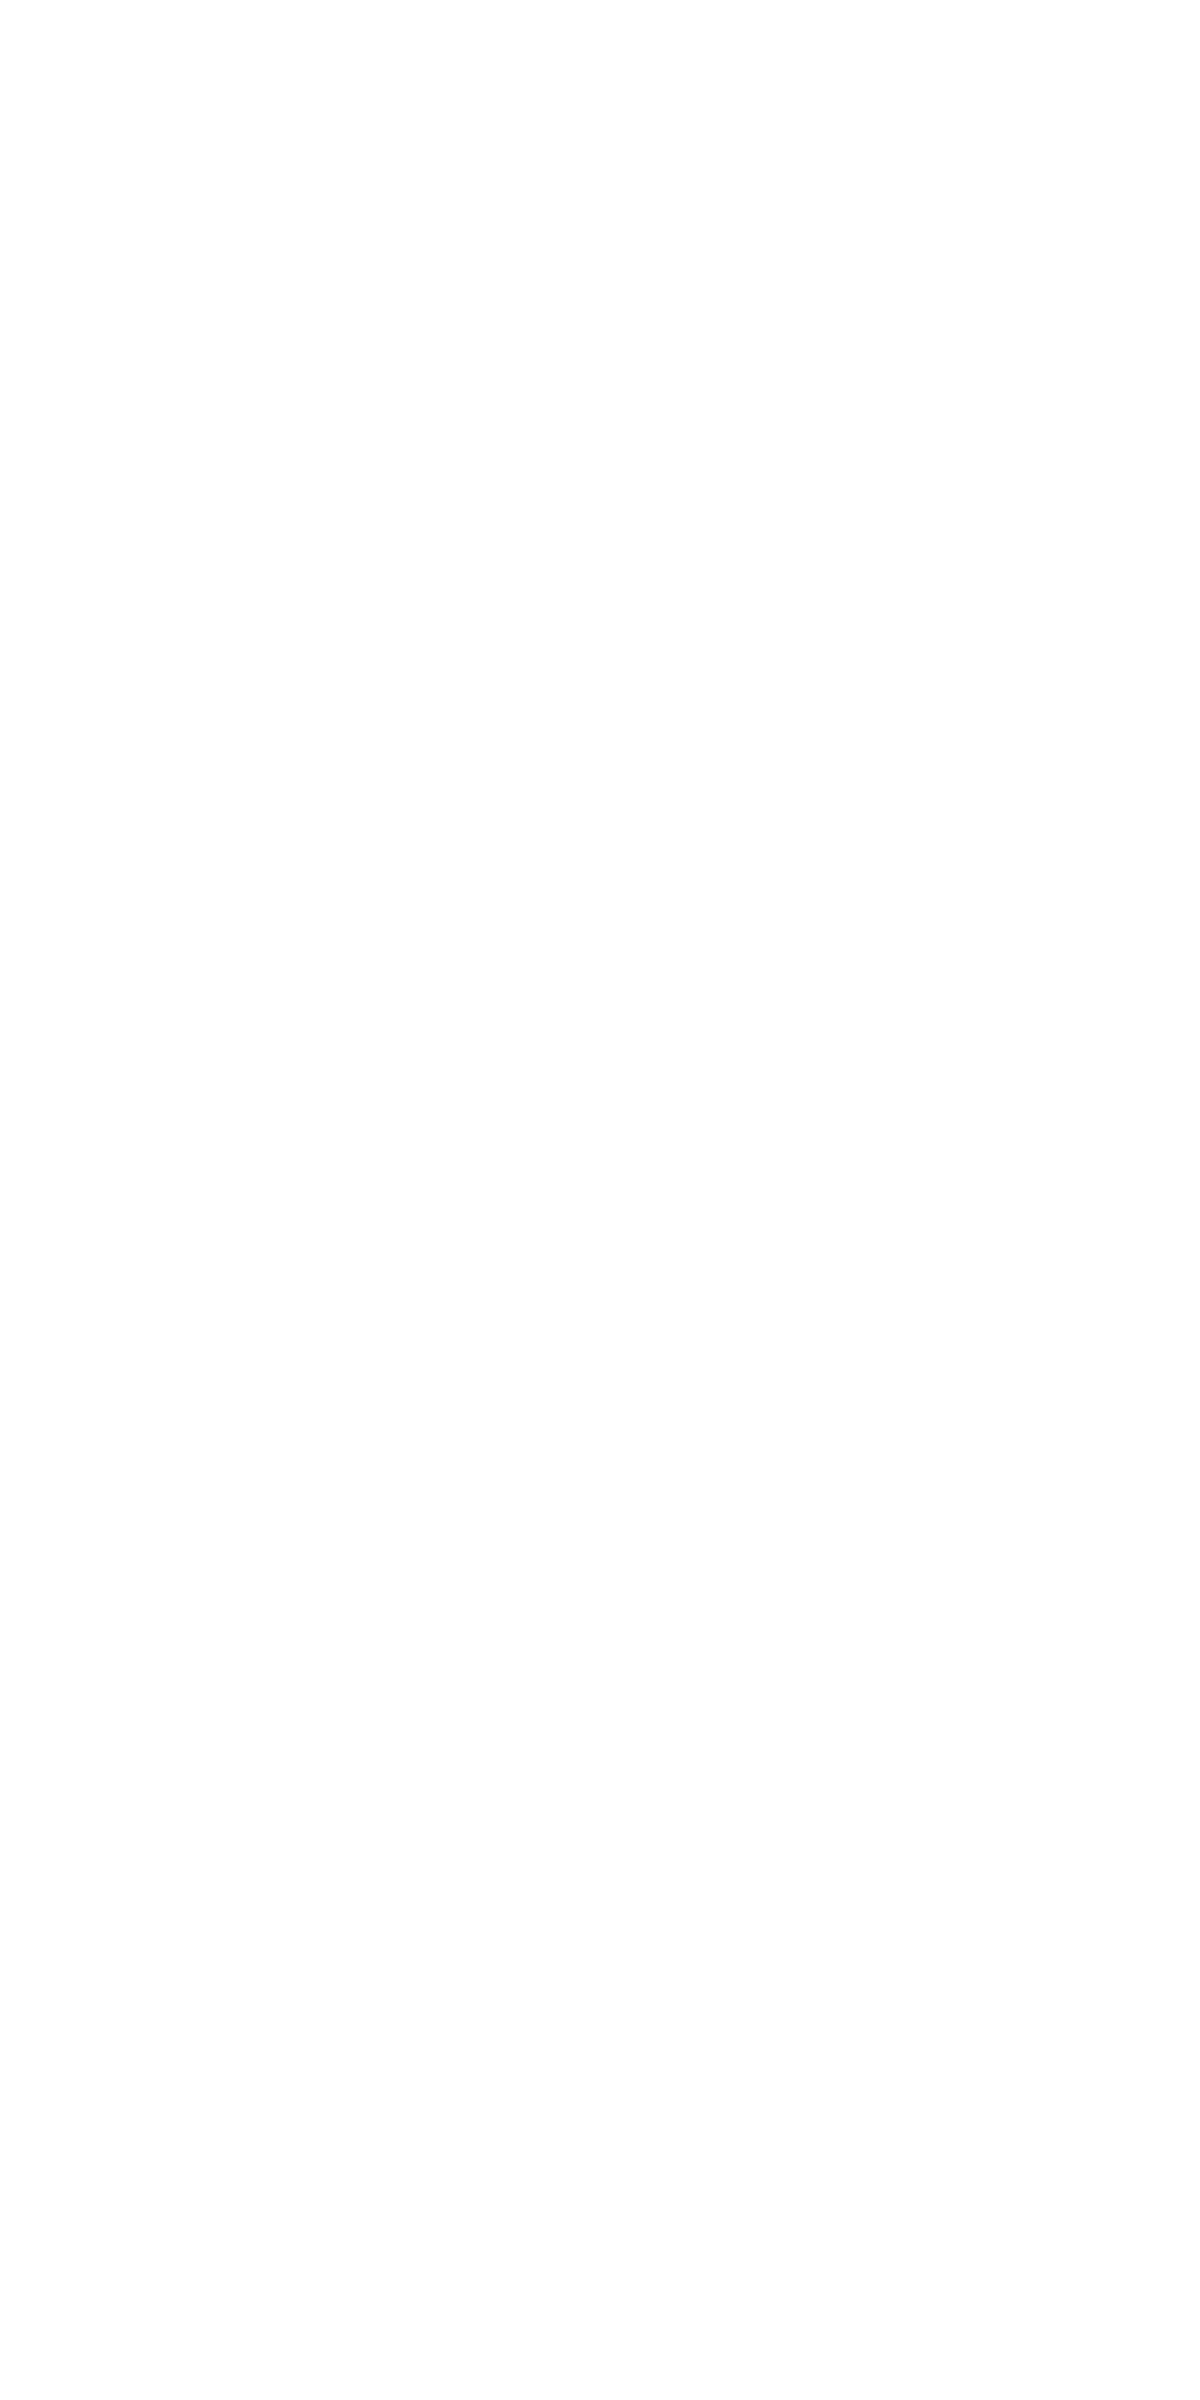

20240216-1552_fly7_Dmel_sP1-ChR_2do_sh_4x4_2024-02-16-155224-0000


<IPython.core.display.Javascript object>


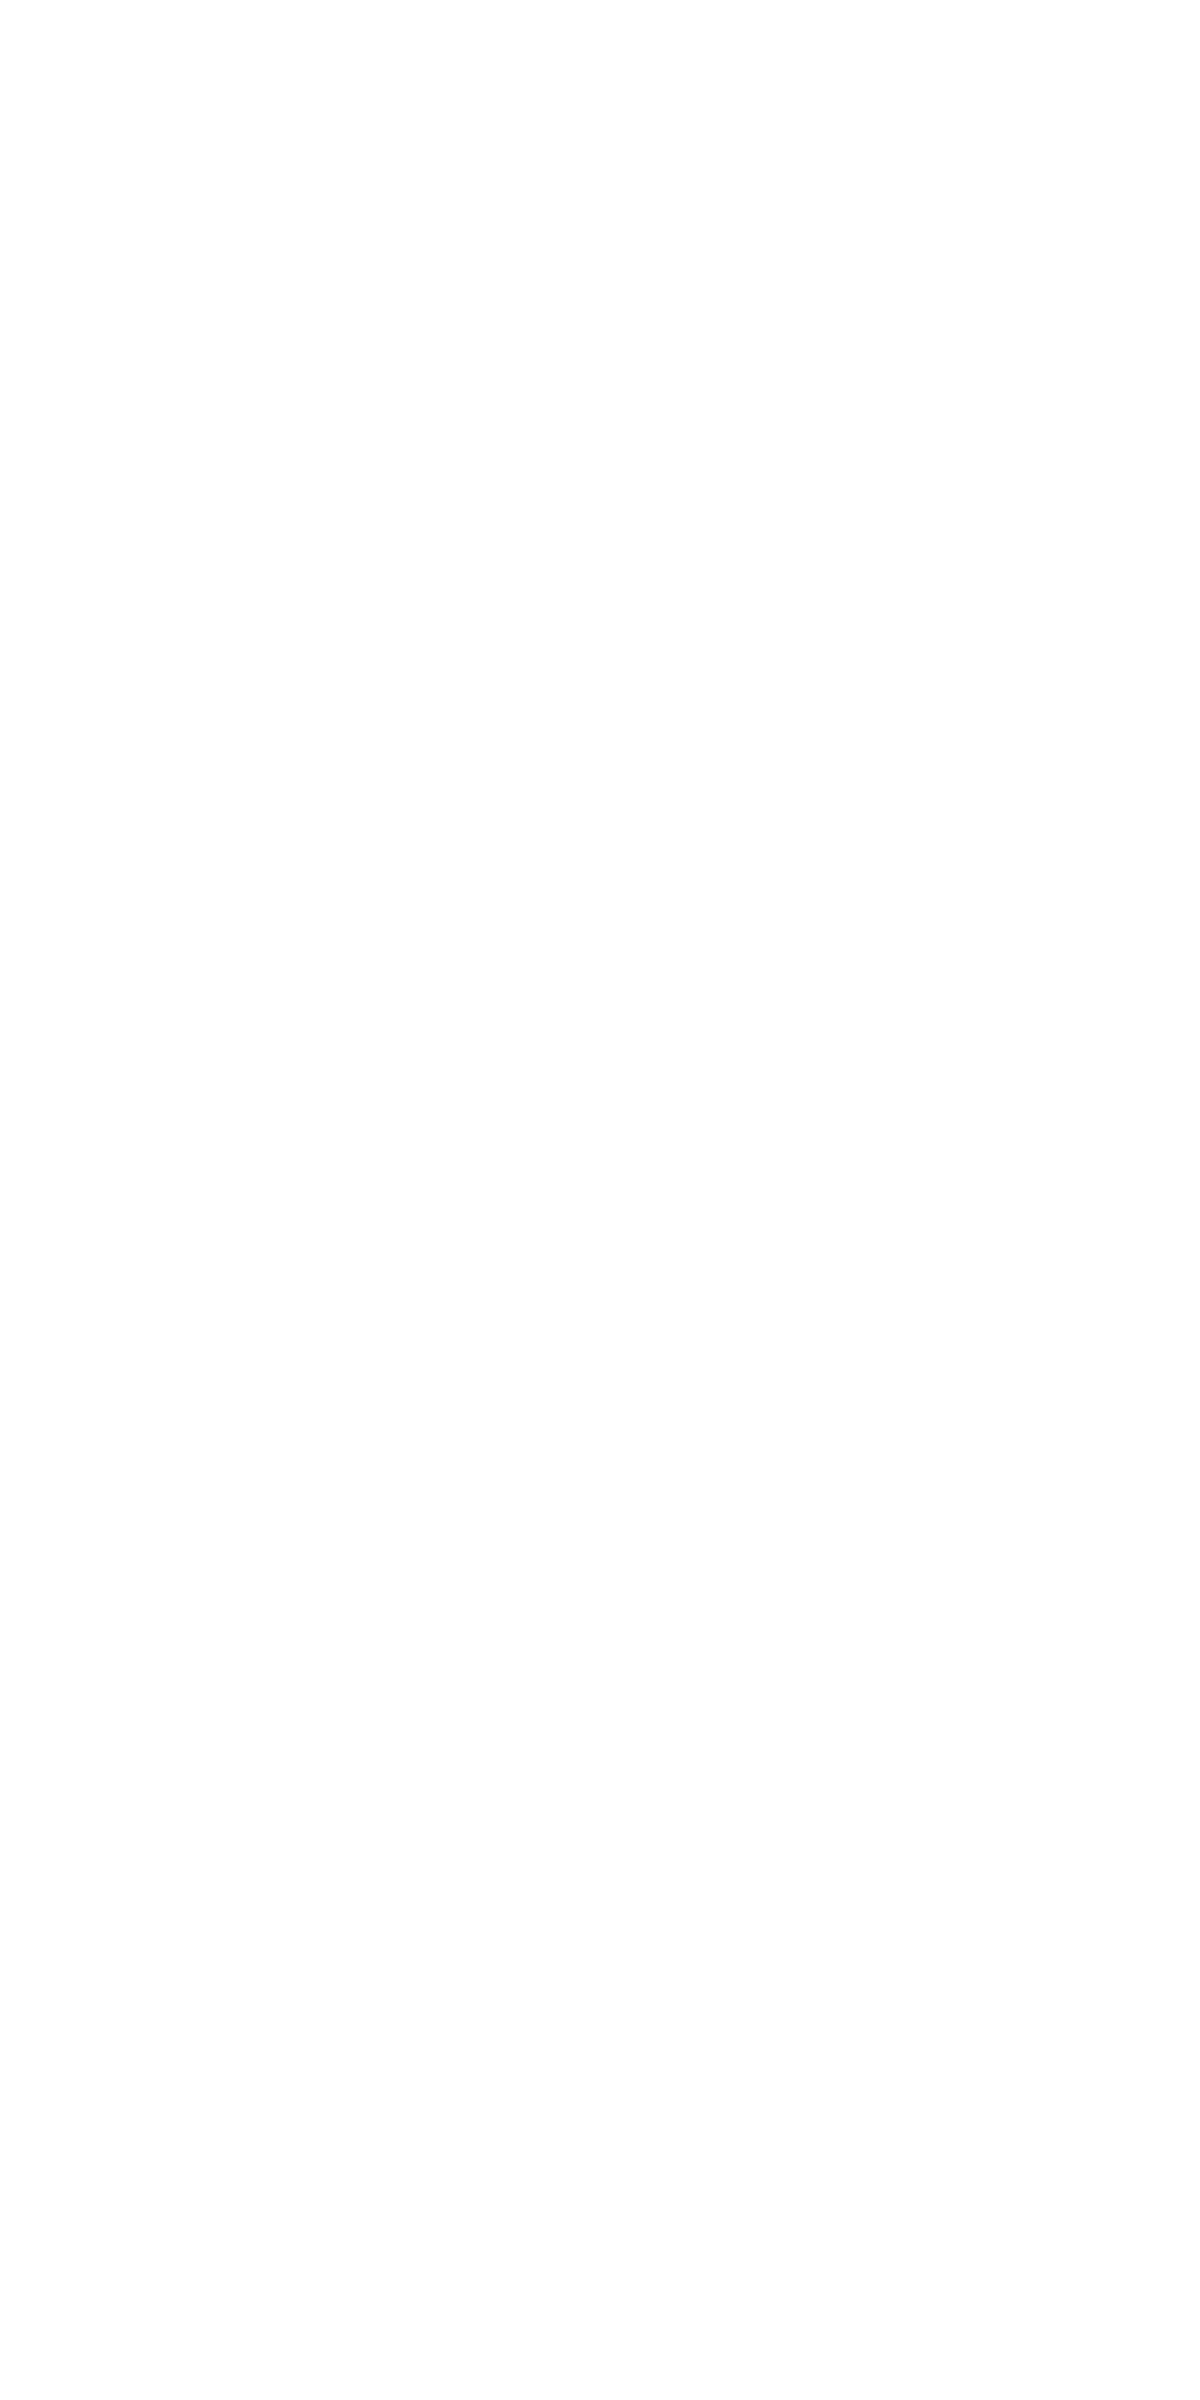

20240216-1443_fly3_Dmel_sP1-ChR_2do_sh_8x8_2024-02-16-144315-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


<IPython.core.display.Javascript object>


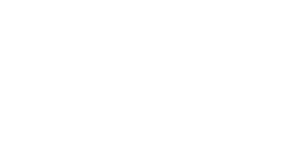

/Users/julianarhee/miniforge3/envs/flytracker/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


20240214-1002_f1_Dele-wt_5do_sh_prj10_sz8x8_2024-02-14-100259-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


<IPython.core.display.Javascript object>


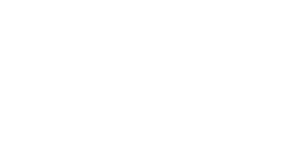

/Users/julianarhee/miniforge3/envs/flytracker/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


20240211-1509_f4_Dyak-splitP1a-CsChR_2do_gh_prj10_sz4x4_2024-02-11-150946-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


<IPython.core.display.Javascript object>


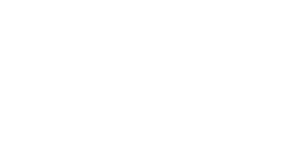

/Users/julianarhee/miniforge3/envs/flytracker/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


20240214-0954_f1_Dele-wt_5do_sh_prj10_sz2x2_2024-02-14-095429-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


<IPython.core.display.Javascript object>


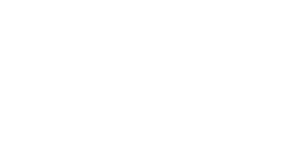

/Users/julianarhee/miniforge3/envs/flytracker/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


20240211-1451_f3_Dyak-splitP1a-CsChR_2do_gh_prj10_sz2x2_2024-02-11-145209-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


<IPython.core.display.Javascript object>


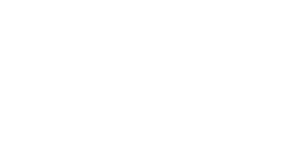

/Users/julianarhee/miniforge3/envs/flytracker/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


20240216-1422_fly3_Dmel_sP1-ChR_2do_sh_6x6_2024-02-16-142505-0000


<IPython.core.display.Javascript object>


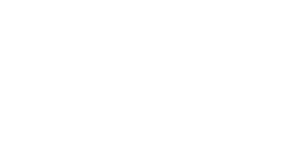

20240216-1541_fly7_Dmel_sP1-ChR_2do_sh_6x6_2024-02-16-154335-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


<IPython.core.display.Javascript object>


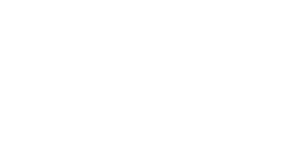

/Users/julianarhee/miniforge3/envs/flytracker/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


20240214-1025_f1_Dele-wt_5do_sh_prj10_sz10x10_2024-02-14-102617-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


<IPython.core.display.Javascript object>


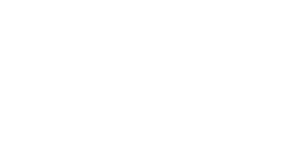

/Users/julianarhee/miniforge3/envs/flytracker/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


20240222-1055_fly1_Dyak_sP1-ChR_2do_sh_8x8_2024-02-22-105904-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


<IPython.core.display.Javascript object>


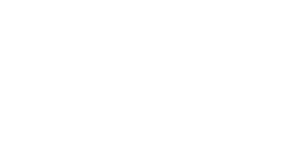

/Users/julianarhee/miniforge3/envs/flytracker/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


20240211-1430_f3_Dyak-splitP1a-CsChR_2do_gh_prj10_sz6x6_2024-02-11-142641-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


<IPython.core.display.Javascript object>


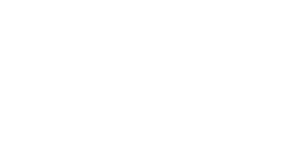

/Users/julianarhee/miniforge3/envs/flytracker/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


20240216-1254_fly1_Dyak_sP1-ChR_2do_sh_8x8_2024-02-16-125559-0000


<IPython.core.display.Javascript object>


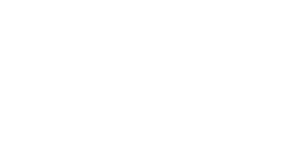

In [215]:
plot_checks=False

d_list = []
for fpath in analyzed_files:
    data_id = os.path.split(fpath)[-1]
    sess_id = data_id.split('DLC')[0]
    print(sess_id)
    flydf = dlc.load_trk_df(fpath, flyid='fly', fps=fps, max_jump=max_jump, cop_ix=None)
    dotdf = dlc.load_trk_df(fpath, flyid='single', fps=fps, max_jump=max_jump, cop_ix=None)
    flydf, dotdf = dlc.get_interfly_params(flydf, dotdf, cop_ix=None)
    # smooth for epochs
    dotdf = dlc.smooth_speed_steps(dotdf)
    if plot_checks:
        fig, ax = pl.subplots(figsize=(8, 5))
        sns.scatterplot(x='time', y='centroid_x', data=dotdf, ax=ax,
                        hue='lin_speed_filt', palette='viridis', edgecolor='none', s=5)
        putil.label_figure(fig, data_id)
        pl.savefig(os.path.join(figdir, '{}_color-vel.png'.format(sess_id)))
        pl.close()
    # get epochs
    step_dict = dlc.get_step_indices(dotdf, speed_var='lin_speed_filt', 
                                 t_start=20, increment=40, n_levels=10)
    if plot_checks:
        fig = dlc.check_speed_steps(dotdf, step_dict)
        putil.label_figure(fig, data_id)
        pl.savefig(os.path.join(figdir, '{}_step-ixs.png'.format(sess_id)))
        pl.close()
    # ADD EPOCHS
    dotdf = dlc.add_speed_epoch(dotdf, step_dict)
    flydf = dlc.add_speed_epoch(flydf, step_dict)
    dotdf = dotdf[dotdf['epoch'] < 10]
    flydf = flydf[flydf['epoch'] < 10]
    # fft
    fft_, fig = do_fft_by_epoch(flydf, dotdf, plot=True)
    putil.label_figure(fig, data_id)
    pl.savefig(os.path.join(figdir, '{}_fft.png'.format(sess_id)))
    pl.close()

    fft_['acquisition'] = sess_id
    sz = int(re.findall('(\d+x\d+)', sess_id)[0].split('x')[0])
    fft_['size'] = sz #int(sz[0][0])
    fft_['species'] = sess_id.split('_')[2]

    d_list.append(fft_)

In [216]:
fft_df = pd.concat(d_list).reset_index()

In [217]:
fft_df['species'] = [v.split('_')[2] for v in fft_df['acquisition']]
# fft_df['size'] = [int(re.findall('(\d+x\d+)', sess_id)[0].split('x')[0]) \
#                   for sess_id in fft_df['acquisition']]

# for acq, df_ in fft_df[fft_df['id']=='dot'].groupby('acquisition'):
#     df_
fft_df['size'].unique()

array([ 4,  6,  8,  2, 10])

In [220]:
fft_df['species'].unique()

fft_df.loc[fft_df['species']=='Dyak-splitP1a-CsChR', 'species'] = 'Dyak'

In [231]:
fft_df.groupby('species')['size'].unique()

species
Dele-wt    [6, 8, 2, 10]
Dmel           [4, 8, 6]
Dyak        [4, 2, 8, 6]
Name: size, dtype: object

<IPython.core.display.Javascript object>


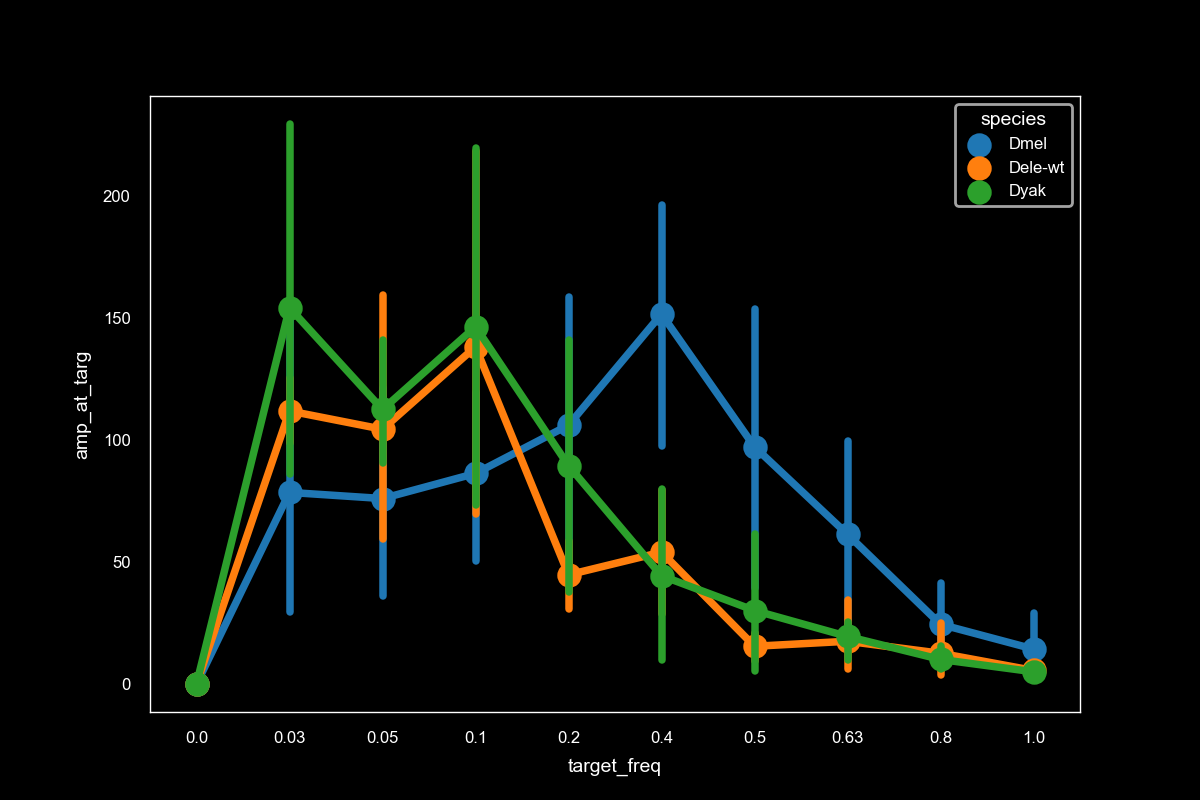

/Users/julianarhee/miniforge3/envs/flytracker/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


<Axes: xlabel='target_freq', ylabel='amp_at_targ'>

In [221]:
fig, ax = pl.subplots()
sns.pointplot(data=fft_df[fft_df['id']=='fly'], ax=ax, hue='species',
               x='target_freq', y='amp_at_targ')


In [222]:
fft_df['size'].unique()

array([ 4,  6,  8,  2, 10])

In [227]:
meandf = fft_df.groupby(['id', 'species', 'size', 'target_freq'])['amp_at_targ'].mean().reset_index()

In [228]:
vmin, vmax = meandf['amp_at_targ'].min(), meandf['amp_at_targ'].max()

<IPython.core.display.Javascript object>


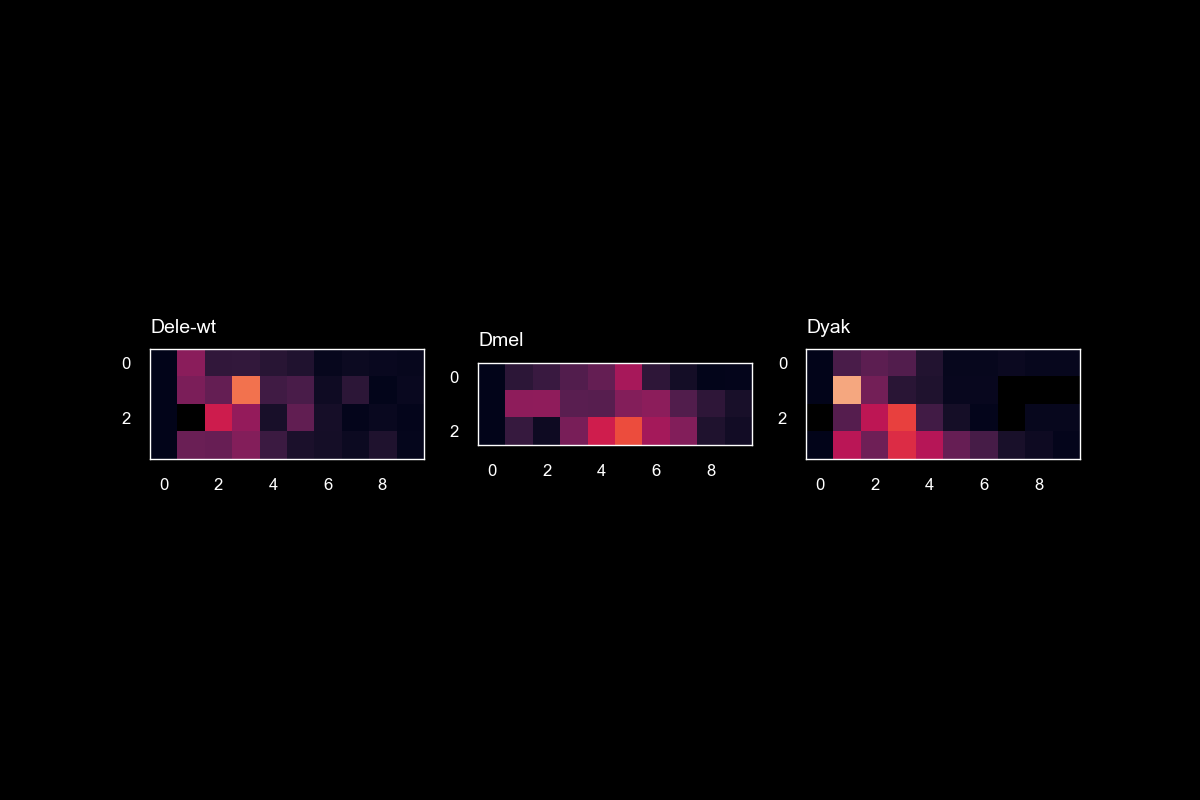

In [229]:
fig, axn = pl.subplots(1, 3)

for ai, (sp, df_) in enumerate(meandf[meandf['id']=='fly'].groupby('species')):
    tuning = df_.pivot_table(values='amp_at_targ', columns=['target_freq'], 
                index=['size'])
    ax=axn[ai]
    ax.set_title(sp, loc='left')
    ax.imshow(tuning.values, vmin=vmin, vmax=vmax)

In [197]:
vmin, vmax

(2.873348772604249e-14, 322.59705839239626)

In [249]:
train_vids = glob.glob(os.path.join(project_dir, 'videos', '*.avi'))

for v in train_vids:
    vname = os.path.split(os.path.splitext(v)[0])[-1]
    #print(vname)
analyzed_vids = [os.path.split(v)[-1].split('DLC')[0] for v in analyzed_files]
print(len(analyzed_vids))
train_vid_names = [os.path.split(os.path.splitext(v)[0])[-1] for v in train_vids]
analyzed_vids.extend(train_vid_names)
analyzed_vids = np.unique(analyzed_vids)
len(analyzed_vids)

14


14

In [250]:
analyzed_vids

array(['20240211-1430_f3_Dyak-splitP1a-CsChR_2do_gh_prj10_sz6x6_2024-02-11-142641-0000',
       '20240211-1451_f3_Dyak-splitP1a-CsChR_2do_gh_prj10_sz2x2_2024-02-11-145209-0000',
       '20240211-1509_f4_Dyak-splitP1a-CsChR_2do_gh_prj10_sz4x4_2024-02-11-150946-0000',
       '20240212-1230_fly3_Dmel_sP1-ChR_3do_sh_4x4_2024-02-12-122911-0000',
       '20240214-0945_f1_Dele-wt_5do_sh_prj10_sz6x6_2024-02-14-094517-0000',
       '20240214-0954_f1_Dele-wt_5do_sh_prj10_sz2x2_2024-02-14-095429-0000',
       '20240214-1002_f1_Dele-wt_5do_sh_prj10_sz8x8_2024-02-14-100259-0000',
       '20240214-1025_f1_Dele-wt_5do_sh_prj10_sz10x10_2024-02-14-102617-0000',
       '20240216-1254_fly1_Dyak_sP1-ChR_2do_sh_8x8_2024-02-16-125559-0000',
       '20240216-1422_fly3_Dmel_sP1-ChR_2do_sh_6x6_2024-02-16-142505-0000',
       '20240216-1443_fly3_Dmel_sP1-ChR_2do_sh_8x8_2024-02-16-144315-0000',
       '20240216-1541_fly7_Dmel_sP1-ChR_2do_sh_6x6_2024-02-16-154335-0000',
       '20240216-1552_fly7_Dmel_sP1-ChR_2do

In [251]:
new_vids = ['20240212-1130_fly2_Dyak_sP1-ChR_3do_sh',
            '20240212-1210_fly3_Dmel_sP1-ChR_3do_sh',
            '20240212-1345_fly4_Dyak_sP1-ChR_3do_sh',
            '20240212-1515_fly6_Dyak_sP1-ChR_3do_sh',
            '20240215-1722_fly1_Dmel_sP1-ChR_3do_sh',
            '20240215-1801_fly2_Dyak_sP1-ChR_3do_sh',
            '20240216-1252_fly1_Dyak_sP1-ChR_2do_sh',
            '20240216-1422_fly3_Dmel_sP1-ChR_2do_sh',
            '20240216-1541_fly7_Dmel_sP1-ChR_2do_sh',
            '20240222-1055_fly1_Dyak_sP1-ChR_2do_sh',
            '20240222-1145_fly3_Dyak_sP1-ChR_2do_sh',
            '20240222-1604_fly7_Dmel_sP1-ChR_2do_sh',
            '20240224-1032_fly2_Dmel_sP1-ChR_2do_sh']
actually_new_vids=[]
for v in new_vids:
    found_ = [vp for vp in analyzed_vids if vp.startswith(v)]
    if len(found_)==0:
        actually_new_vids.append(v)

In [252]:
actually_new_vids

['20240212-1130_fly2_Dyak_sP1-ChR_3do_sh',
 '20240212-1210_fly3_Dmel_sP1-ChR_3do_sh',
 '20240212-1345_fly4_Dyak_sP1-ChR_3do_sh',
 '20240212-1515_fly6_Dyak_sP1-ChR_3do_sh',
 '20240215-1722_fly1_Dmel_sP1-ChR_3do_sh',
 '20240215-1801_fly2_Dyak_sP1-ChR_3do_sh',
 '20240216-1252_fly1_Dyak_sP1-ChR_2do_sh',
 '20240222-1145_fly3_Dyak_sP1-ChR_2do_sh',
 '20240222-1604_fly7_Dmel_sP1-ChR_2do_sh',
 '20240224-1032_fly2_Dmel_sP1-ChR_2do_sh']